# Time Series Forecasting

https://medium.com/analytics-vidhya/time-series-forecasting-using-tensorflow-rkt109-ea858d8e49c6

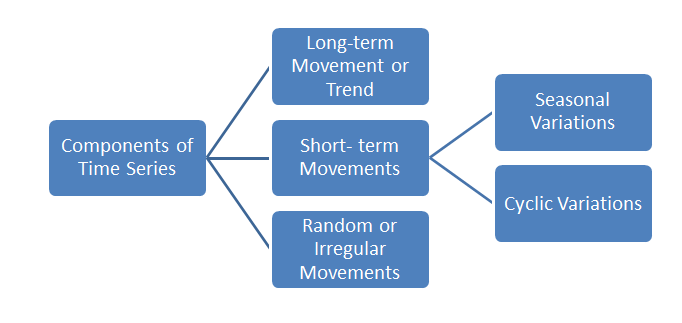

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

df = pd.read_csv('sunspots.csv', header=0, index_col=0)

In [2]:
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [3]:
import csv
time_step = []
sunspots = []

with open('sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
print('series: {}'.format(series[:5]))
print('time: {}'.format(time[:5]))

series: [ 96.7 104.3 116.7  92.8 141.7]
time: [0 1 2 3 4]


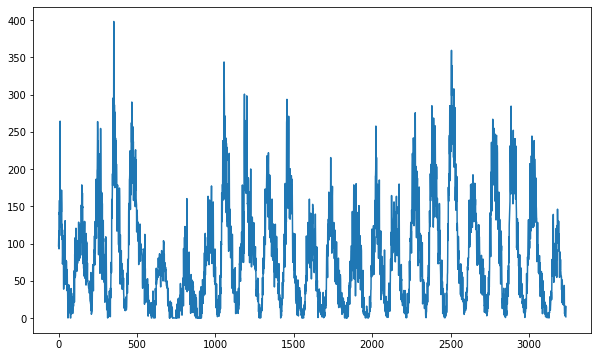

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(time, series)

## Preparing the data

In [5]:
# we split our data into training set and validation set
split_time = 3000
time_training = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = time[split_time:]

## Constructing a Window dataset

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
shuffle_buffer_size = 1000
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(x_train.shape)

(3000,)


In [10]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
 tf.keras.layers.Conv1D(filters=60, kernel_size=5,
 strides=1, padding="causal",
 activation="relu",
 input_shape=[None, 1]),
 tf.keras.layers.LSTM(60, return_sequences=True),
 tf.keras.layers.LSTM(60, return_sequences=True),
 tf.keras.layers.Dense(30, activation="relu"),
 tf.keras.layers.Dense(10, activation="relu"),
 tf.keras.layers.Dense(1),
 tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [12]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
 optimizer=optimizer,
 metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
12/12 [==============================] - 3s 267ms/step - loss: 49.2553 - mae: 49.7528
Epoch 2/500
12/12 [==============================] - 3s 249ms/step - loss: 31.9244 - mae: 32.4193
Epoch 3/500
12/12 [==============================] - 3s 231ms/step - loss: 26.9624 - mae: 27.4569
Epoch 4/500
12/12 [==============================] - 3s 221ms/step - loss: 24.3279 - mae: 24.8220
Epoch 5/500
12/12 [==============================] - 3s 212ms/step - loss: 22.8910 - mae: 23.3844
Epoch 6/500
12/12 [==============================] - 3s 215ms/step - loss: 21.4642 - mae: 21.9575
Epoch 7/500
12/12 [==============================] - 3s 232ms/step - loss: 20.4533 - mae: 20.9465
Epoch 8/500
12/12 [==============================] - 3s 216ms/step - loss: 20.1460 - mae: 20.6391
Epoch 9/500
12/12 [==============================] - 3s 215ms/step - loss: 19.6721 - mae: 20.1646
Epoch 10/500
12/12 [==============================] - 3s 223ms/step - loss: 20.1432 - mae: 20.6357
Epoch 11/500
12/12 

12/12 [==============================] - 2s 208ms/step - loss: 16.9830 - mae: 17.4729
Epoch 84/500
12/12 [==============================] - 3s 212ms/step - loss: 17.0024 - mae: 17.4923
Epoch 85/500
12/12 [==============================] - 3s 209ms/step - loss: 17.0662 - mae: 17.5560
Epoch 86/500
12/12 [==============================] - 2s 208ms/step - loss: 17.2385 - mae: 17.7283
Epoch 87/500
12/12 [==============================] - 3s 212ms/step - loss: 17.3147 - mae: 17.8046
Epoch 88/500
12/12 [==============================] - 2s 207ms/step - loss: 17.2763 - mae: 17.7664
Epoch 89/500
12/12 [==============================] - 3s 209ms/step - loss: 17.1322 - mae: 17.6222
Epoch 90/500
12/12 [==============================] - 2s 208ms/step - loss: 16.9445 - mae: 17.4344
Epoch 91/500
12/12 [==============================] - 3s 210ms/step - loss: 16.9084 - mae: 17.3983
Epoch 92/500
12/12 [==============================] - 3s 210ms/step - loss: 16.9229 - mae: 17.4128
Epoch 93/500
12/12 [===

12/12 [==============================] - 3s 273ms/step - loss: 16.5674 - mae: 17.0568
Epoch 166/500
12/12 [==============================] - 3s 231ms/step - loss: 16.5618 - mae: 17.0511
Epoch 167/500
12/12 [==============================] - 3s 219ms/step - loss: 16.5626 - mae: 17.0522
Epoch 168/500
12/12 [==============================] - 3s 211ms/step - loss: 16.5844 - mae: 17.0737
Epoch 169/500
12/12 [==============================] - 3s 250ms/step - loss: 16.5111 - mae: 17.0002
Epoch 170/500
12/12 [==============================] - 3s 235ms/step - loss: 16.8596 - mae: 17.3492
Epoch 171/500
12/12 [==============================] - 2s 203ms/step - loss: 16.8394 - mae: 17.3288
Epoch 172/500
12/12 [==============================] - 3s 220ms/step - loss: 16.5626 - mae: 17.0520
Epoch 173/500
12/12 [==============================] - 3s 231ms/step - loss: 16.9216 - mae: 17.4112
Epoch 174/500
12/12 [==============================] - 3s 226ms/step - loss: 16.8580 - mae: 17.3478
Epoch 175/500


12/12 [==============================] - 3s 215ms/step - loss: 16.5569 - mae: 17.0459
Epoch 248/500
12/12 [==============================] - 3s 221ms/step - loss: 16.5717 - mae: 17.0609
Epoch 249/500
12/12 [==============================] - 3s 216ms/step - loss: 16.3653 - mae: 16.8542
Epoch 250/500
12/12 [==============================] - 3s 215ms/step - loss: 16.3956 - mae: 16.8843
Epoch 251/500
12/12 [==============================] - 3s 216ms/step - loss: 16.5494 - mae: 17.0387
Epoch 252/500
12/12 [==============================] - 3s 213ms/step - loss: 16.3305 - mae: 16.8196
Epoch 253/500
12/12 [==============================] - 3s 223ms/step - loss: 16.3204 - mae: 16.8096
Epoch 254/500
12/12 [==============================] - 3s 215ms/step - loss: 16.4664 - mae: 16.9552
Epoch 255/500
12/12 [==============================] - 3s 222ms/step - loss: 16.4157 - mae: 16.9042
Epoch 256/500
12/12 [==============================] - 3s 233ms/step - loss: 16.2837 - mae: 16.7726
Epoch 257/500


12/12 [==============================] - 3s 242ms/step - loss: 16.1455 - mae: 16.6339
Epoch 330/500
12/12 [==============================] - 3s 260ms/step - loss: 16.1211 - mae: 16.6097
Epoch 331/500
12/12 [==============================] - 3s 236ms/step - loss: 16.1151 - mae: 16.6038
Epoch 332/500
12/12 [==============================] - 4s 307ms/step - loss: 16.2110 - mae: 16.7000
Epoch 333/500
12/12 [==============================] - 3s 257ms/step - loss: 16.1484 - mae: 16.6372
Epoch 334/500
12/12 [==============================] - 3s 238ms/step - loss: 16.2499 - mae: 16.7387
Epoch 335/500
12/12 [==============================] - 3s 221ms/step - loss: 16.1453 - mae: 16.6343
Epoch 336/500
12/12 [==============================] - 3s 268ms/step - loss: 16.0627 - mae: 16.5513
Epoch 337/500
12/12 [==============================] - 3s 221ms/step - loss: 16.0951 - mae: 16.5837
Epoch 338/500
12/12 [==============================] - 3s 252ms/step - loss: 16.0350 - mae: 16.5232
Epoch 339/500


12/12 [==============================] - 3s 238ms/step - loss: 16.0406 - mae: 16.5294
Epoch 412/500
12/12 [==============================] - 3s 290ms/step - loss: 15.8805 - mae: 16.3688
Epoch 413/500
12/12 [==============================] - 3s 275ms/step - loss: 15.9182 - mae: 16.4066
Epoch 414/500
12/12 [==============================] - 3s 244ms/step - loss: 15.9000 - mae: 16.3886
Epoch 415/500
12/12 [==============================] - 2s 200ms/step - loss: 15.8371 - mae: 16.3254
Epoch 416/500
12/12 [==============================] - 3s 251ms/step - loss: 15.8901 - mae: 16.3781
Epoch 417/500
12/12 [==============================] - 3s 242ms/step - loss: 15.9073 - mae: 16.3956
Epoch 418/500
12/12 [==============================] - 3s 258ms/step - loss: 15.8431 - mae: 16.3313
Epoch 419/500
12/12 [==============================] - 3s 226ms/step - loss: 15.8609 - mae: 16.3490
Epoch 420/500
12/12 [==============================] - 3s 286ms/step - loss: 15.8953 - mae: 16.3840
Epoch 421/500


12/12 [==============================] - 3s 213ms/step - loss: 15.8286 - mae: 16.3171
Epoch 494/500
12/12 [==============================] - 3s 210ms/step - loss: 15.6528 - mae: 16.1405
Epoch 495/500
12/12 [==============================] - 2s 208ms/step - loss: 15.7022 - mae: 16.1901
Epoch 496/500
12/12 [==============================] - 2s 208ms/step - loss: 15.8357 - mae: 16.3241
Epoch 497/500
12/12 [==============================] - 3s 210ms/step - loss: 15.6969 - mae: 16.1849
Epoch 498/500
12/12 [==============================] - 3s 210ms/step - loss: 15.9033 - mae: 16.3914
Epoch 499/500
12/12 [==============================] - 3s 210ms/step - loss: 16.2090 - mae: 16.6980
Epoch 500/500
12/12 [==============================] - 3s 210ms/step - loss: 15.9929 - mae: 16.4819


<Figure size 432x288 with 0 Axes>

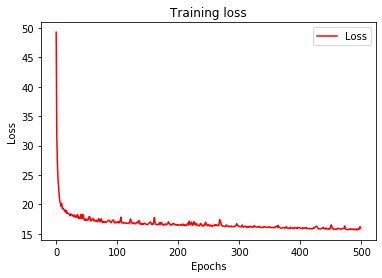

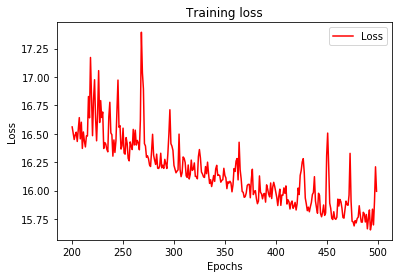

<Figure size 432x288 with 0 Axes>

In [16]:
# — — — — — — — — — — — — — — — — — — — — — — — — — — — — — -
# Retrieve a list of list results on training and test data
# sets for each training epoch
# — — — — — — — — — — — — — — — — — — — — — — — — — — — — — -
loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs
# — — — — — — — — — — — — — — — — — — — — — — — — 
# Plot training and validation loss per epoch
# — — — — — — — — — — — — — — — — — — — — — — — — 
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()
zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)
# — — — — — — — — — — — — — — — — — — — — — — — — 
# Plot training and validation loss per epoch
# — — — — — — — — — — — — — — — — — — — — — — — — 
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

## Predict


In [24]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [30]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

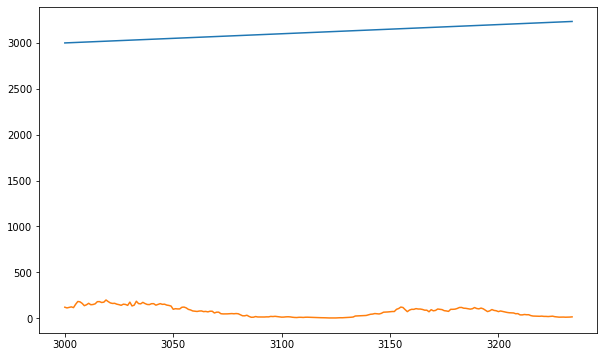

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)